<a href="https://colab.research.google.com/github/judex22/Vector-Space-Semantics-for-Similarity-between-Eastenders-Characters/blob/main/Vector_Space_Semantics_for_Text_Similarity(WordCount).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NLP Assignment 2 (40% of grade): Vector Space Semantics for Similarity between Eastenders Characters (Word Count Unigram Vector with pre-processing and POS Tagging)

In this assignment, you will be creating a vector representation of a document containing lines spoken by a character in the Eastenders script data (i.e. from the file `training.csv`), then improving that representation such that each character vector is maximially distinguished from the other character documents. This distinction is measured by how well a simple information retrieval classification method can select documents from validation and test data as belonging to the correct class of document (i.e. deciding which character spoke the lines by measuring the similarity of those character document vectors to those built in training).

As the lines are not evenly distributed in terms of frequency, this coursework stipulates you can only use a maximum of the first **400 lines** of each character in the training data `training.csv` to create the training documents, and a maximum of the first **40 lines** in the test data (from `test.csv`). This makes it more challenging, as number of lines spoken by a character can't be used directly or otherwise as a feature.

A simple vector representation for each character document is done for you to start with in this code, as is the pipeline of similarity-based information retrieval based evaluation. You need to improve the character vector representations by pre-processing, feature extraction and transformation techniques, as per Questions 1-6 below, which you need to complete as instructed.

**Refer to the material in units 8-9 for conceptual background.**

In [ ]:
#QUESTION 01-03

In [ ]:
!pip install nltk

In [ ]:
import string
import re
import numpy as np
from numpy.linalg import norm
import pandas as pd
from collections import Counter, OrderedDict

import seaborn as sns
import matplotlib.pyplot as plt

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk.tag import CRFTagger

from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

%matplotlib inline
pd.options.display.max_colwidth=500

In [ ]:
# Load in training data and display in pandas dataframe
train_path='training.csv'
all_train_data = pd.read_csv(train_path,  delimiter="\t", skip_blank_lines = True)
test_path ='test.csv'
test_data = pd.read_csv(test_path,  delimiter="\t", skip_blank_lines = True)

# Inspect
all_train_data

,Episode,Scene,Scene_info,Character_name,Line,Gender
0,1350,1,DESERTED CAR PARK EXT NIGHT,SHIRLEY,"Look at ya, not a mark on ya. And you think you're an unlucky man.",FEMALE
1,1350,1,DESERTED CAR PARK EXT NIGHT,OTHER,Shirl...,MALE
2,1350,2,R&R INT NIGHT,JACK,Oi. Where have you been? Huh? What were the texts about?,MALE
3,1350,2,R&R INT NIGHT,RONNIE,Nothing. Nothing. I'll be with you in two minutes yeah?,FEMALE
4,1350,2,R&R INT NIGHT,JACK,"Well I've got mates here I wanted to have a chat with them, instead I've been serving behind the bar.",MALE
...,...,...,...,...,...,...
15314,1399,55,SQUARE EXT DAY LIGHT,OTHER,"Dad? Okay ... alright, just one drink alright. But that's all. It doesn't mean anything. It's just a drink.",MALE
15315,1399,55,SQUARE EXT DAY LIGHT,MAX,Thanks Bradley. Thanks mate... It means the world to me...,MALE
15316,1399,55,SQUARE EXT DAY LIGHT,OTHER,You alright...,MALE
15317,1399,55,SQUARE EXT DAY LIGHT,MAX,"Yeah, yeah, yeah. I'm fine.",MALE


In [ ]:
# Split into training and test data for heldout validation with random samples of 9:1 train/heldout split
from random import shuffle, seed

seed(0) # set a seed for reproducibility so same split is used each time

epsiode_scene_column = all_train_data.Episode.astype(str) + "-" + all_train_data.Scene.astype(str)
all_train_data['episode_scene'] = epsiode_scene_column
episode_scenes = sorted(list(set([x for x in epsiode_scene_column.values]))) # need to sort to ensure same initial order

shuffle(episode_scenes)

print(len(episode_scenes))
episode_split = int(0.9*len(episode_scenes))
training_ep_scenes = episode_scenes[:episode_split]
test_ep_scenes = episode_scenes[episode_split:]                           #final test set
print(len(training_ep_scenes), len(test_ep_scenes))

def train_or_heldout_eps(val):
    if val in training_ep_scenes:
        return "training"
    return "heldout"

all_train_data['train_heldout'] = all_train_data['episode_scene'].apply(train_or_heldout_eps)

1394
1254 140


In [ ]:
print('Raw Data: ',np.shape(all_train_data))
train_data = all_train_data[all_train_data['train_heldout']=='training']
val_data = all_train_data[all_train_data['train_heldout']=='heldout']
print('Train set: ',np.shape(train_data))
print('Validation set: ',np.shape(val_data))

Raw Data:  (15319, 8)
Train set:  (13638, 8)
Validation set:  (1681, 8)


In [ ]:
## Observing data between most similar pair in heldout vs training data (For question 3 analysis)

train_data[train_data['Character_name']=='PHIL'].head(20)       # look at index 1151

,Episode,Scene,Scene_info,Character_name,Line,Gender,episode_scene,train_heldout
805,1352,21,BRIDGE STREET EXT DAY LIGHT,PHIL,Yes?,MALE,1352-21,training
807,1352,21,BRIDGE STREET EXT DAY LIGHT,PHIL,So?,MALE,1352-21,training
809,1352,21,BRIDGE STREET EXT DAY LIGHT,PHIL,Why? What've I got to worry about?,MALE,1352-21,training
934,1352,31,VIC DOWNSTAIRS INT NIGHT,PHIL,Come again?,MALE,1352-31,training
936,1352,31,VIC DOWNSTAIRS INT NIGHT,PHIL,Thanks.,MALE,1352-31,training
938,1352,31,VIC DOWNSTAIRS INT NIGHT,PHIL,What the--?,MALE,1352-31,training
940,1352,31,VIC DOWNSTAIRS INT NIGHT,PHIL,What're you doing?,MALE,1352-31,training
1113,1353,19,VIC DOWNSTAIRS INT DAY LIGHT,PHIL,Seeing your bloke later?,MALE,1353-19,training
1115,1353,19,VIC DOWNSTAIRS INT DAY LIGHT,PHIL,Jack then.,MALE,1353-19,training
1117,1353,19,VIC DOWNSTAIRS INT DAY LIGHT,PHIL,"Look, I couldn't care what you pair get up to, long as he ain't distracted from the real business in hand.",MALE,1353-19,training


In [ ]:
display(val_data[val_data['Character_name']=='JACK'])       # look at index 7913

,Episode,Scene,Scene_info,Character_name,Line,Gender,episode_scene,train_heldout
1038,1353,12,VIC DOWNSTAIRS INT DAY LIGHT,JACK,Came to see you.,MALE,1353-12,heldout
1040,1353,12,VIC DOWNSTAIRS INT DAY LIGHT,JACK,What time will you be finished?,MALE,1353-12,heldout
1042,1353,12,VIC DOWNSTAIRS INT DAY LIGHT,JACK,But you might be free for lunch?,MALE,1353-12,heldout
1044,1353,12,VIC DOWNSTAIRS INT DAY LIGHT,JACK,We need to talk.,MALE,1353-12,heldout
1046,1353,12,VIC DOWNSTAIRS INT DAY LIGHT,JACK,Yeah. Business stuff.,MALE,1353-12,heldout
1048,1353,12,VIC DOWNSTAIRS INT DAY LIGHT,JACK,Yeah.,MALE,1353-12,heldout
1050,1353,12,VIC DOWNSTAIRS INT DAY LIGHT,JACK,That's right.,MALE,1353-12,heldout
1052,1353,12,VIC DOWNSTAIRS INT DAY LIGHT,JACK,One o'clock at the club?,MALE,1353-12,heldout
1054,1353,12,VIC DOWNSTAIRS INT DAY LIGHT,JACK,I most certainly will.,MALE,1353-12,heldout
1056,1353,12,VIC DOWNSTAIRS INT DAY LIGHT,JACK,"Not yet, no.",MALE,1353-12,heldout


In [ ]:
if False:
    # A simpler alternative to the above, but where a high split means some characters
    # may be left out
    print('Raw Data: ',np.shape(all_train_data))
    idx = int(0.9 * np.shape(all_train_data)[0])
    train_data = all_train_data[:idx]
    val_data = all_train_data[idx:]
    print('Train set: ',np.shape(train_data))
    print('Validation set: ',np.shape(val_data))

In [ ]:
# Create one document per character
def create_character_document_from_dataframe(df, max_line_count):
    """Returns a dict with the name of the character as key,
    their lines joined together as a single string, with end of line _EOL_
    markers between them.

    ::max_line_count:: the maximum number of lines to be added per character
    """
    character_docs = {}
    character_line_count = {}
    for line, name, gender in zip(df.Line, df.Character_name, df.Gender):
        if not name in character_docs.keys():
            character_docs[name] = ""
            character_line_count[name] = 0
        if character_line_count[name]==max_line_count:
            continue
        character_docs[name] += str(line)   + " _EOL_ "  # adding an end-of-line token


        character_line_count[name]+=1
    print("lines per character", character_line_count)
    return character_docs

In [ ]:
# print out the number of words each character has in the training set
# only use the first 360 lines of each character
train_character_docs = create_character_document_from_dataframe(train_data, max_line_count=360)
print('Num. Characters: ',len(train_character_docs.keys()),"\n")
total_words = 0
for name in train_character_docs.keys():
    print(name, 'Number of Words: ',len(train_character_docs[name].split()))
    total_words += len(train_character_docs[name].split())
print("total words", total_words)

lines per character {'SHIRLEY': 360, 'OTHER': 360, 'JACK': 360, 'RONNIE': 360, 'TANYA': 360, 'SEAN': 360, 'ROXY': 360, 'HEATHER': 360, 'MAX': 360, 'IAN': 360, 'JANE': 360, 'STACEY': 360, 'PHIL': 360, 'MINTY': 360, 'CHRISTIAN': 342, 'CLARE': 352}
Num. Characters:  16 

SHIRLEY Number of Words:  3848
OTHER Number of Words:  3244
JACK Number of Words:  4435
RONNIE Number of Words:  3442
TANYA Number of Words:  3786
SEAN Number of Words:  3637
ROXY Number of Words:  3838
HEATHER Number of Words:  4098
MAX Number of Words:  4363
IAN Number of Words:  4332
JANE Number of Words:  3648
STACEY Number of Words:  3913
PHIL Number of Words:  3635
MINTY Number of Words:  4005
CHRISTIAN Number of Words:  3738
CLARE Number of Words:  4344
total words 62306


In [ ]:
import string
import re

def pre_process(character_text):
    """Pre-process all the concatenated lines of a character,
    using tokenization, spelling normalization and other techniques.

    Initially just a tokenization on white space. Improve this for Q1.

    ::character_text:: a string with all of one character's lines
    """
    text=character_text.translate(str.maketrans('','',string.punctuation))
    tokens = text.split()
    tokens= [x.lower() for x in tokens]
    stop_words=set(stopwords.words("english"))
    tokens=[i for i in tokens if i not in stop_words]
    tokens=[x for x in tokens if not x.isdigit()]
    lemmatizer=WordNetLemmatizer()
    tokens=[lemmatizer.lemmatize(w,pos='v') for w in tokens]


    if False:
        tokens = character_text.split()   # just a simple tokenization, to be replaced

        print(tokens[:][0:25])    #printing first 25 tokens of each line

    return tokens

In [ ]:
# create list of pairs of (character name, pre-processed character)
training_corpus = [(name, pre_process(doc)) for name, doc in sorted(train_character_docs.items())]
train_labels = [name for name, doc in training_corpus]

In [ ]:
def to_feature_vector_dictionary(character_doc, extra_features):
    """Converts a list of pre-processed tokens and extra features
    to a Dictionary as a function of the tokens.

    Initially just a simple count. Improve this for Q2.

    ::character_doc:: a list of pre-processed tokens
    ::extra_features:: any extra features for the character to be added to feature vector dict
    """
    def generate_N_grams(text,ngram):
         #function to get N-gram tokens(in this case N=1 i:e Unigram)
        words=text
        temp=zip(*[words[i:] for i in range(0,ngram)])
        ans=[' '.join(ngram) for ngram in temp]
        return ans

    unigram_token=generate_N_grams(character_doc,1)
    extra_features=nltk.pos_tag(unigram_token)
    counts = Counter(extra_features)
    feat_dict = dict(counts)


    if True:
        print(list(feat_dict.items())[0:5])          # first 5 elements of each dictionary row of pos_tagged tokens

    return feat_dict

In [ ]:
all_train_data.head()

,Episode,Scene,Scene_info,Character_name,Line,Gender,episode_scene,train_heldout
0,1350,1,DESERTED CAR PARK EXT NIGHT,SHIRLEY,"Look at ya, not a mark on ya. And you think you're an unlucky man.",FEMALE,1350-1,training
1,1350,1,DESERTED CAR PARK EXT NIGHT,OTHER,Shirl...,MALE,1350-1,training
2,1350,2,R&R INT NIGHT,JACK,Oi. Where have you been? Huh? What were the texts about?,MALE,1350-2,training
3,1350,2,R&R INT NIGHT,RONNIE,Nothing. Nothing. I'll be with you in two minutes yeah?,FEMALE,1350-2,training
4,1350,2,R&R INT NIGHT,JACK,"Well I've got mates here I wanted to have a chat with them, instead I've been serving behind the bar.",MALE,1350-2,training


In [ ]:
corpusVectorizer = DictVectorizer()   # corpusVectorizor which will just produce sparse vectors from feature dicts
# Any matrix transformers (e.g. tf-idf transformers) should be initialized here

def create_document_matrix_from_corpus(corpus, fitting=False):
    """Method which fits different vectorizers
    on data and returns a matrix.

    Currently just does simple conversion to matrix by vectorizing the dictionary. Improve this for Q3.

    ::corpus:: a list of (class_label, document) pairs.
    ::fitting:: a boolean indicating whether to fit/train the vectorizers (should be true on training data)
    """
    if fitting:
        corpusVectorizer.fit([to_feature_vector_dictionary(doc, []) for name, doc in corpus])
    doc_feature_matrix = corpusVectorizer.transform([to_feature_vector_dictionary(doc, []) for name, doc in corpus])

    #training_feature_matrix[0].toarray()
    return doc_feature_matrix

training_feature_matrix = create_document_matrix_from_corpus(training_corpus, fitting=True)

[(('lesley', 'NN'), 2), (('im', 'NNS'), 3), (('really', 'RB'), 10), (('glad', 'JJ'), 1), (('must', 'MD'), 2)]
[(('dot', 'NN'), 11), (('eol', 'NN'), 160), (('wheres', 'VBZ'), 1), (('dot', 'JJ'), 4), (('people', 'NNS'), 3)]
[(('want', 'NN'), 1), (('go', 'VBP'), 19), (('home', 'NN'), 8), (('eol', 'NN'), 144), (('someone', 'NN'), 1)]
[(('perhaps', 'RB'), 1), (('cook', 'VB'), 1), (('something', 'NN'), 8), (('like', 'IN'), 12), (('martin', 'NN'), 1)]
[(('oi', 'NN'), 1), (('huh', 'NN'), 1), (('texts', 'NN'), 1), (('eol', 'RB'), 24), (('well', 'RB'), 27)]
[(('maybe', 'RB'), 1), (('eol', 'NN'), 174), (('know', 'VBP'), 13), (('eol', 'VBZ'), 12), (('like', 'IN'), 17)]
[(('want', 'JJ'), 1), (('talk', 'NN'), 5), (('sean', 'JJ'), 5), (('eol', 'NN'), 162), (('youre', 'NN'), 25)]
[(('hows', 'NNS'), 1), (('go', 'VBP'), 28), (('billy', 'RB'), 1), (('new', 'JJ'), 1), (('place', 'NN'), 1)]
[(('shirl', 'NN'), 1), (('eol', 'NN'), 150), (('go', 'VBP'), 19), (('eol', 'RB'), 28), (('right', 'RB'), 5)]
[(('yes'

In [ ]:
training_feature_matrix

<16x5533 sparse matrix of type '<class 'numpy.float64'>'
	with 14184 stored elements in Compressed Sparse Row format>

In [ ]:
# get the validation data- only 40 lines used for each character
val_character_docs = create_character_document_from_dataframe(val_data, max_line_count=40)
print('Num. Characters: ',len(val_character_docs.keys()),"\n")
total_words = 0
for name in val_character_docs.keys():
    print(name, 'Num of Words: ',len(val_character_docs[name].split()))
    total_words += len(val_character_docs[name].split())
print("total words", total_words)

# create list of pairs of (character name, pre-processed character)
val_corpus = [(name, pre_process(doc)) for name, doc in sorted(val_character_docs.items())]
val_labels = [name for name, doc in val_corpus]

lines per character {'TANYA': 40, 'MAX': 40, 'SEAN': 35, 'SHIRLEY': 40, 'OTHER': 40, 'STACEY': 40, 'RONNIE': 40, 'JACK': 40, 'PHIL': 40, 'IAN': 40, 'JANE': 40, 'ROXY': 40, 'HEATHER': 40, 'MINTY': 40, 'CHRISTIAN': 40, 'CLARE': 40}
Num. Characters:  16 

TANYA Num of Words:  438
MAX Num of Words:  737
SEAN Num of Words:  366
SHIRLEY Num of Words:  329
OTHER Num of Words:  357
STACEY Num of Words:  412
RONNIE Num of Words:  464
JACK Num of Words:  351
PHIL Num of Words:  475
IAN Num of Words:  508
JANE Num of Words:  458
ROXY Num of Words:  392
HEATHER Num of Words:  411
MINTY Num of Words:  470
CHRISTIAN Num of Words:  489
CLARE Num of Words:  405
total words 7062


In [ ]:
# Just transform the val_feature_matrix, don't fit
val_feature_matrix = create_document_matrix_from_corpus(val_corpus, fitting=False)

[(('cheap', 'JJ'), 1), (('aftershavethinks', 'NNS'), 1), (('run', 'VBP'), 1), (('chip', 'NN'), 1), (('shop', 'NN'), 2)]
[(('right', 'RB'), 1), (('well', 'RB'), 7), (('weve', 'VB'), 1), (('chat', 'NNS'), 1), (('really', 'RB'), 2)]
[(('think', 'VB'), 2), (('id', 'NN'), 1), (('walk', 'VBP'), 1), (('home', 'NN'), 1), (('eol', 'NN'), 19)]
[(('delicious', 'JJ'), 1), (('dyou', 'NN'), 1), (('learn', 'VBP'), 1), (('cook', 'NN'), 2), (('like', 'IN'), 4)]
[(('come', 'VB'), 1), (('see', 'NN'), 1), (('eol', 'JJ'), 12), (('time', 'NN'), 2), (('finish', 'JJ'), 1)]
[(('leave', 'VB'), 1), (('eol', 'NNS'), 2), (('dont', 'JJ'), 2), (('want', 'VBP'), 2), (('steven', 'VBN'), 1)]
[(('tanya', 'NN'), 2), (('wanna', 'VBP'), 1), (('give', 'VB'), 1), (('oscar', 'RP'), 1), (('new', 'JJ'), 1)]
[(('leave', 'VB'), 1), (('eol', 'NNS'), 2), (('well', 'RB'), 4), (('might', 'MD'), 4), (('unite', 'VB'), 1)]
[(('eol', 'NN'), 21), (('anything', 'NN'), 2), (('wanna', 'JJ'), 1), (('tell', 'NN'), 2), (('eol', 'RB'), 3)]
[(('n

In [ ]:
val_feature_matrix

<16x5533 sparse matrix of type '<class 'numpy.float64'>'
	with 2325 stored elements in Compressed Sparse Row format>

In [ ]:
def compute_cosine_similarity(v1, v2):
    """Takes a pair of vectors v1 and v2 (1-d arrays e.g. [0, 0.5, 0.5])
    returns the cosine similarity between the vectors
    """
    # compute cosine similarity manually
    manual_cosine_similarity = np.dot(v1, v2)  /(norm(v1) * norm(v2))

    return manual_cosine_similarity

In [ ]:
def compute_IR_evaluation_scores(train_feature_matrix, test_feature_matrix, train_labels, test_labels):
    """
    Computes an information retrieval based on training data feature matrix and test data feature matrix
    returns 4-tuple:
    ::mean_rank:: mean of the ranking of the target document in terms of similarity to the query/test document
    1 is the best possible score.
    ::mean_cosine_similarity:: mean cosine similarity score for the target document vs. the test document of the same class
    ::accuracy:: proportion of test documents correctly classified
    ::df:: a data frame with all the similarity measures of the test documents vs. train documents

    params:
    ::train_feature_matrix:: a numpy matrix N x M shape where N = number of characters M = number of features
    ::test_feature_matrix::  a numpy matrix N x M shape where N = number of characters M = number of features
    ::train_labels:: a list of character names for the training data in order consistent with train_feature_matrix
    ::test_labels:: a list of character names for the test data in order consistent with test_feature_matrix
    """
    rankings = []
    all_cosine_similarities = []
    pairwise_cosine_similarity = []
    pairs = []
    correct = 0
    for i, target in enumerate(test_labels):
        # compare the left out character against the mean
        idx = i
        fm_1 = test_feature_matrix.toarray()[idx]
        all_sims = {}
        # print("target:", target)
        for j, other in enumerate(train_labels):
            fm_2 = train_feature_matrix.toarray()[j]
            manual_cosine_similarity = compute_cosine_similarity(fm_1, fm_2)
            pairs.append((target, other))
            pairwise_cosine_similarity.append(manual_cosine_similarity)
            if other == target:
                all_cosine_similarities.append(manual_cosine_similarity)
            all_sims[other] = manual_cosine_similarity

            # print(target, other, manual_cosine_similarity)
        sorted_similarities = sorted(all_sims.items(),key=lambda x:x[1],reverse=True)
        # print(sorted_similarities)
        ranking = {key[0]: rank for rank, key in enumerate(sorted_similarities, 1)}
        # print("Ranking for target", ranking[target])
        if ranking[target] == 1:
            correct += 1
        rankings.append(ranking[target])
        # print("*****")
    mean_rank = np.mean(rankings)
    mean_cosine_similarity = np.mean(all_cosine_similarities)
    accuracy = correct/len(test_labels)
    print("mean rank", np.mean(rankings))
    print("mean cosine similarity", mean_cosine_similarity)
    print(correct, "correct out of", len(test_labels), "/ accuracy:", accuracy )
    print("\n")

    # get a dafaframe showing all the similarity scores of training vs test docs
    df = pd.DataFrame({'doc1': [x[0] for x in pairs], 'doc2': [x[1] for x in pairs],
                       'similarity': pairwise_cosine_similarity})

    # display characters which are most similar and least similar
    df.loc[[df.similarity.values.argmax(), df.similarity.values.argmin()]]


    new_df_max=df.nlargest(5,'similarity')
    new_df_min=df.nsmallest(5,'similarity')
    print("Largest 5 Similarity:\n",new_df_max,"\n")
    print("Smallest 5 Similarity:\n",new_df_min)


    return (mean_rank, mean_cosine_similarity, accuracy, df)

In [ ]:
def plot_heat_map_similarity(df):
    """Takes a dataframe with header 'doc1, doc2, similarity'
    Plots a heatmap based on the similarity scores.
    """
    test_labels =  sorted(list(set(df.sort_values(['doc1'])['doc1'])))
    # add padding 1.0 values to either side
    cm = [[1.0,] * (len(test_labels)+2)]
    for target in test_labels:
        new_row = [1.0]
        for x in df.sort_values(['doc1', 'doc2'])[df['doc1']==target]['similarity']:
            new_row.append(x)
        new_row.append(1.0)
        cm.append(new_row)
    cm.append([1.0,] * (len(test_labels)+2))
    #print(cm)
    labels = [""] + test_labels + [""]
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Similarity matrix between documents as vectors')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):

            text = ax.text(j, i, round(cm[i][j],3),
                           ha="center", va="center", color="w")

    plt.xlabel('Training Vector Doc')
    plt.ylabel('Test Vector Doc')
    #fig.tight_layout()
    plt.show()

In [ ]:
mean_rank, mean_cosine_simliarity, acc, df = compute_IR_evaluation_scores(training_feature_matrix, val_feature_matrix, train_labels, val_labels)

mean rank 2.375
mean cosine similarity 0.8381335127317905
9 correct out of 16 / accuracy: 0.5625


Largest 5 Similarity:
         doc1       doc2  similarity
85      JANE       JANE    0.873757
73      JACK       PHIL    0.870207
223  SHIRLEY      TANYA    0.865285
217  SHIRLEY       PHIL    0.862380
80      JANE  CHRISTIAN    0.861356 

Smallest 5 Similarity:
        doc1       doc2  similarity
54      IAN        MAX    0.770703
96      MAX  CHRISTIAN    0.771517
125   MINTY    SHIRLEY    0.772029
126   MINTY     STACEY    0.772377
174  RONNIE     STACEY    0.773674


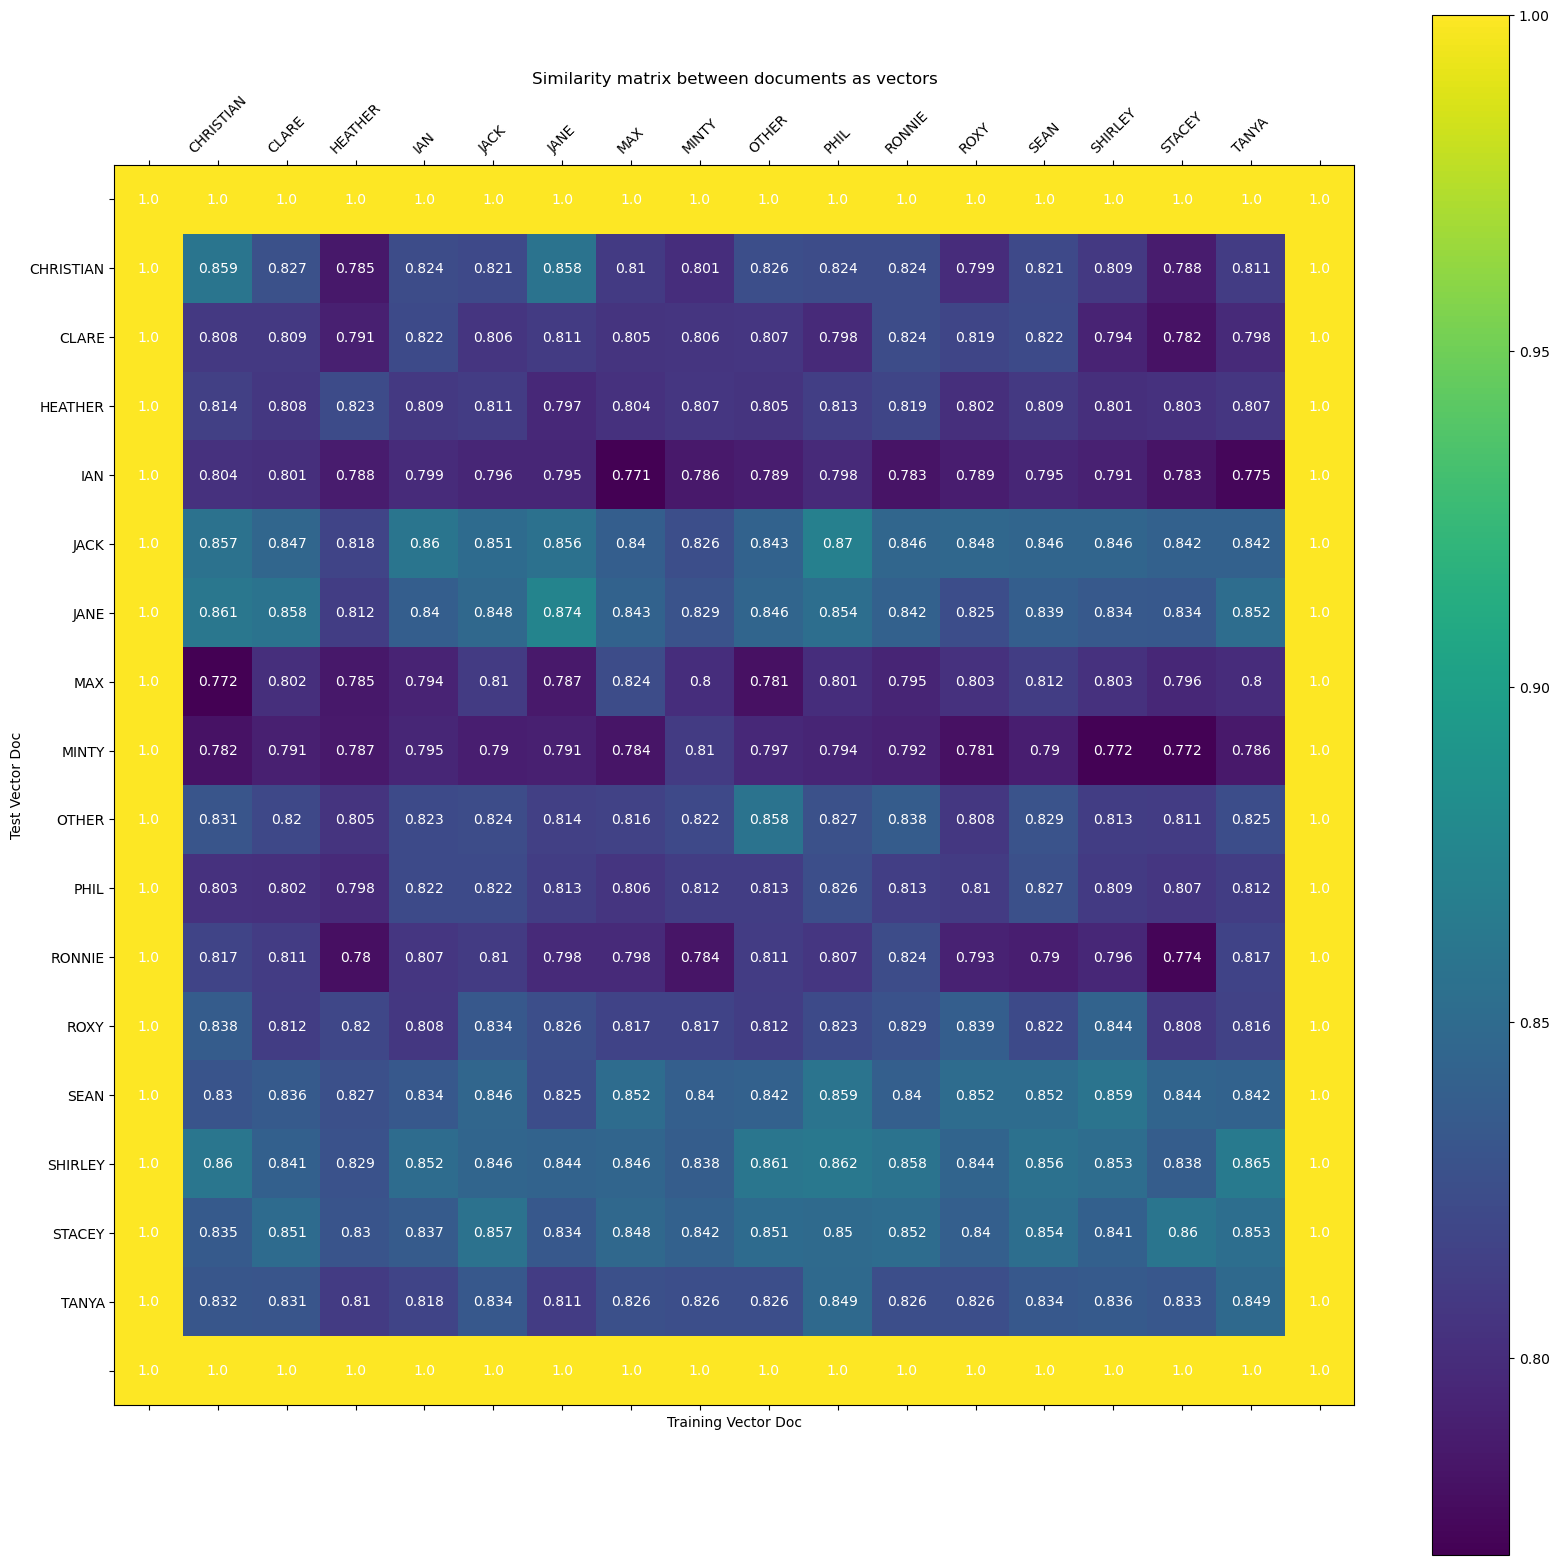

In [ ]:
plot_heat_map_similarity(df)

# Q1. Improve pre-processing (20 marks)
Using the pre-processing techniques you have learned in the module, improve the `pre_process` function above, which currently just tokenizes text based on white space.

When developing, use the 90% train and 10% validation data split from the training file, using the first 360 lines from the training split and first 40 lines from the validation split, as per above. To check the improvements by using the different techniques, use the `compute_IR_evaluation_scores` function as above. The **mean rank** is the main metric you need to focus on improving throughout this assignment, where the target/best possible performance is **1** (i.e. all test/validation data character documents are closest to their corresponding training data character documents) and the worst is **16**. Initially the code in this template achieves a mean rank of **5.12**  and accuracy of **0.3125** on the test set and a mean rank of **4.5** and accuracy of **0.25** on the validation set - you should be looking to improve those, particularly getting the mean rank as close to 1 as possible.


# Q2. Improve linguistic feature extraction (20 marks)
Use the feature extraction techniques you have learned to improve the `to_feature_vector_dictionary` function above. Examples of extra features could include extracting n-grams of different lengths and including POS-tags. You could also use sentiment analysis or another text classifier's result when applied to the features for each character document. You could even use a gender classifier trained on the same data using the GENDER column **(but DO NOT USE the GENDER column directly in the features for the final vector)**.

You could use feature selection/reduction with techniques like minimum/maximum document frequency and/or feature selection like k-best selection using different statistical tests https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html. Again, develop on 90% training and 10% validation split and note the effect/improvement in mean rank with the techniques you use.

# Q3. Analyse the similarity results (10 marks)
From your system so far run on the 90%/10% training/validation split, identify the heldout character vectors ranked closest to each character's training vector which are not the character themselves, and those furthest away, as displayed using the `plot_heat_map_similarity` function. In your report, try to ascribe reasons why this is the case, particularly for those where there isn't a successful highest match between the target character in the training set and that character's vector in the heldout set yet. Observations you could make include how their language use is similar, resulting in similar word or ngram features.